In [1]:
import mne 
import matplotlib.pyplot as plot
import numpy as np
from tqdm import tqdm_notebook
from itertools import product

from crosspy.preprocessing.seeg.seeg_utils import is_different_ref_pair
from crosspy.core.methods import cplv_pairwise
%matplotlib inline

import mne

from crosspy.core.methods import cplv, cplv_pairwise
from crosspy.preprocessing.seeg.support import clean_montage, drop_monopolar_channels
from crosspy.preprocessing.seeg.seeg_utils import create_reference_mask, get_electrode_distance
from crosspy.preprocessing.signal import preprocess_data_morlet

import os

import numpy as np
import glob

import matplotlib.pyplot as plt

import scipy as sp
import scipy.cluster

import sklearn
from sklearn import metrics

import re
import pandas as pd

import pickle

import tqdm

from bids import BIDSLayout

from collections import defaultdict

from statsmodels.stats.multitest import multipletests

from ripples_utils import make_bipolar

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans

from pathlib import Path

from matplotlib.ticker import ScalarFormatter

In [2]:
from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.166, 0.43, 0.43),
                   (0.33, 0.7, 0.7),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0, 0.6, 0.6)),

         'green': ((0.0, 0.4, 0.4),
                   (0.166, 0.7, 0.7),
                   (0.33, 0.8, 0.8),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0,0.0, 0.0)),

         'blue':  ((0.0, 0.8, 0.8),
                   (0.166, 1.0, 1.0),
                   (0.33, 1.0, 1.0),
                   (0.5, 0.4, 0.4),
                   (0.66, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

ripples_cmap = LinearSegmentedColormap('ripplescmap', cdict1)
ripples_blue = ripples_cmap(0)
ripples_red = ripples_cmap(0.99)
ripples_orange = ripples_cmap(0.7)

In [3]:
fname = '/home/vladka/../gabriele/saline_seeg_only_raw.fif'
bipo_saline = mne.io.read_raw_fif(fname)
bipo_saline.crop(tmax=600)

Opening raw data file /home/vladka/../gabriele/saline_seeg_only_raw.fif...
Isotrak not found
    Range : 0 ... 632999 =      0.000 ...   632.999 secs
Ready.


<Raw  |  saline_seeg_only_raw.fif, n_channels x n_times : 18 x 600001 (600.0 sec), ~40 kB, data not loaded>

In [4]:
def compute_psd_scaled(bipo):
    psds, freqs = mne.time_frequency.psd_welch(bipo, n_fft=2048, reject_by_annotation=False)
    psds *= 1e3 * 1e3

    np.log10(np.maximum(psds, np.finfo(float).tiny), out=psds)
    psds *= 10
    
    return freqs, psds

In [5]:
picks_seeg = mne.pick_types(bipo_saline.info, meg=False, seeg=True)
saline_amp = np.zeros(50)
            
frequencies = np.array([  2.        ,   2.26576777,   2.5668518 ,   2.90794503,
         3.29436407,   3.73213197,   4.22807216,   4.78991482,
         5.42641731,   6.14750073,   6.96440451,   7.88986164,
         8.9382971 ,  10.12605275,  11.47164198,  12.99603834,
        14.72300241,  16.67945217,  18.89588258,  21.40684088,
        24.25146506,  27.47409397,  31.12495832,  35.26096371,
        39.94657756,  45.254834  ,  51.26847217,  58.08122594,
        65.79928491,  74.54294953,  84.44850629,  95.67035191,
       110.        , 130.        , 150.        , 170.        ,
       190.        , 210.        , 230.        , 250.        ,
       270.        , 290.        , 310.        , 330.        ,
       350.        , 370.        , 390.        , 410.        ,
       430.        , 450.        ]);

n_filters = frequencies.shape[0]
ii = 0
picks_seeg = mne.pick_types(bipo_saline.info, meg=False, ecog=True)
n_channels = bipo_saline.get_data().shape[0]
N = (n_channels*(n_channels-1))/2
N = (n_channels**2)-n_channels

plv_spectrum = np.ndarray((n_filters, n_channels, n_channels, 2), dtype=complex)

mask = np.ones((n_channels, n_channels), dtype=int)

for i,j in product(range(n_channels), range(n_channels)):
    
    ch1, ch2 = bipo_saline.ch_names[i],bipo_saline.ch_names[j]

    ch1 = ch1.split('-')
    ch2 = ch2.split('-')
    
    if len(set(ch1) & set(ch2)) > 0 or i == j :
        mask[i,j] = 0

bipo_saline.load_data()
bipo_saline.notch_filter(np.arange(50, 500, 50), n_jobs=32)
bipo_saline.filter(None, 440, verbose=False, n_jobs=32)

for fidx, freq in enumerate(tqdm_notebook(frequencies)): 
    tmp_data = bipo_saline.get_data().copy()
    
#     tmp_data -= tmp_data.mean(axis=1).reshape((-1,1))  
    
    d = mne.time_frequency.tfr_array_morlet(tmp_data[np.newaxis, ...], bipo_saline.info['sfreq'], [freq],
                                                       7.5, verbose=False, n_jobs=32).squeeze()
    cplv, cplv_surr = cplv_pairwise(d, return_surr=True)

    plv_spectrum[ii,:,:,0] = (cplv * mask )
    plv_spectrum[ii,:,:,1] = (cplv_surr * mask )
    ii += 1
    
    saline_amp[fidx] = np.abs(d).mean()

Reading 0 ... 600000  =      0.000 ...   600.000 secs...
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   3 out of  18 | elapsed:    1.6s remaining:    8.0s
[Parallel(n_jobs=32)]: Done   7 out of  18 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=32)]: Done  11 out of  18 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=32)]: Done  15 out of  18 | elapsed:    1.8s remaining:    0.4s
[Parallel(n_jobs=32)]: Done  18 out of  18 | elapsed:    1.9s finished


In [6]:
pickle.dump({'ref_mask': mask.astype(bool), 'cplv_spectrum': plv_spectrum[...,0], 'surrogate_spectrum': plv_spectrum[..., 1]}, 
            open('saline_spectrum.pickle', 'wb'))

In [7]:
saline_psd = compute_psd_scaled(bipo_saline)

Effective window size : 2.048 (s)


In [8]:
df = pd.read_csv('../seeg_phases/data/SEEG_redux_BIDS/convert_results.csv')
df_num_idx = df.set_index('subject_number')

header=['subject', 'contact', 'EZ', 'GMPI']
ez_data = pd.read_csv('202001_SEEG_ripple_Cohort_Contacts.csv', sep=';', header=None)
ez_grouped = ez_data.groupby(0)

cluster_data = pd.read_csv('Subject_agg_cluster_labels.csv')
subject_to_cluster = cluster_data.set_index('subject_number')

def create_ez_mask(ez_chans):
    res = np.zeros((ez_chans.shape[0], ez_chans.shape[0]), dtype=bool)
    for i in range(ez_chans.shape[0]):
        for j in range(ez_chans.shape[0]):
            res[i,j] = ez_chans[i] == 0 and ez_chans[j] == 0
    
    return res


def is_bipolar(x):
    a, c = x.split('-')
    
    return len(c) > 0

def estimate_mean_with_bootstrap(spectrum, N_rounds=1000):
    all_indices = np.arange(spectrum.shape[0])
        
    res = np.zeros((N_rounds, ) + spectrum.shape[1:])
    for idx in range(N_rounds):
        round_indices = np.random.choice(all_indices, size=all_indices.shape[0])
        res[idx] = spectrum[round_indices].mean(axis=0)
        
    return res

In [9]:
root_path = os.path.join('../seeg_phases/data/gonogo_data')
layout = BIDSLayout(root_path)

In [10]:
from pathlib import Path

In [11]:
def get_bipolar_contacts(channel_names):
    anode = list()
    cathode = list()
    dropList = list()
    for name in channel_names:
        if re.match(r'^[A-Z][\']?[0-9]+$',name):
            splitLabel = re.split(r'([0-9]+)',name)
            if splitLabel:
                cathodeName = splitLabel[0]+str(int(splitLabel[1])+1)
                if cathodeName in channel_names:
                    anode.append(name)
                    cathode.append(cathodeName) 
        else:
            dropList.append(name)
    return (anode, cathode)

def make_bipolar(data_fname, montage_filename, lowpass_frequency=None, notch=True, raw_bipolar=False):
    raw = mne.io.read_raw_edf(data_fname, preload=False, verbose=False)
    mne.rename_channels(raw.info, lambda name: re.sub(r'(POL|SEEG)\s+', '', name).strip())

    channel_types = dict()

    for ch in raw.ch_names:
        result = re.match(r'^[A-Z][\']?\d+', ch)
        if result:
            channel_types[ch] = 'seeg'

    raw.set_channel_types(channel_types)
    
    if raw_bipolar:
        anode, cathode = get_bipolar_contacts(raw.ch_names)
    else:
        montage = pd.read_csv(montage_filename, delimiter=',', names=['name', 'anode', 'cathode'])
        montage.drop_duplicates(subset='name', inplace=True)

        anode,cathode = clean_montage(raw.ch_names, montage.anode.tolist(), montage.cathode.tolist())

    raw.load_data()

    bipo = mne.set_bipolar_reference(raw, list(anode), list(cathode), copy=True, verbose=False)
    bipo = drop_monopolar_channels(bipo)
    bipo.drop_channels(bipo.info['bads'])

    picks_seeg = mne.pick_types(bipo.info, meg=False, seeg=True)

    non_seeg_chans = [ch_name for ch_idx, ch_name in enumerate(bipo.ch_names) if not(ch_idx in picks_seeg) or len(ch_name.split('-')) == 1]
    bipo.drop_channels(non_seeg_chans)
    
    if notch:
        bipo.notch_filter(np.arange(50, bipo.info['sfreq']//2, 50), n_jobs=32)
    
    if not(lowpass_frequency is None):
        bipo.filter(None, lowpass_frequency, verbose=False, n_jobs=32)

    return bipo

In [18]:
subjectwise_psds = list()

for path in Path('data/saline_amplifier').rglob('*.edf'):   
    bipo = make_bipolar(str(path), montage_filename=None, notch=True, lowpass_frequency=440, raw_bipolar=True)
    freqs, psds = compute_psd_scaled(bipo)
    subjectwise_psds.append(psds.mean(axis=0))
    
for path in Path('../seeg_phases/data/gonogo_data/').rglob('*.edf'):   
    subj_num = re.findall(r'\d+', str(path))[0]
    
    if subj_num in ('02', '06'):
        continue
    
    bipo = make_bipolar(str(path), montage_filename=None, notch=True, lowpass_frequency=440, raw_bipolar=True)
    freqs, psds = compute_psd_scaled(bipo)
    subjectwise_psds.append(psds.mean(axis=0))
    
subjectwise_psds = np.array(subjectwise_psds)

Effective window size : 2.048 (s)


/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


<ipython-input-11-0e8483854dfa>:18: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['MISC FLEX DX_213']
  raw = mne.io.read_raw_edf(data_fname, preload=False, verbose=False)


Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


<ipython-input-11-0e8483854dfa>:18: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(data_fname, preload=False, verbose=False)


Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


<ipython-input-11-0e8483854dfa>:18: RuntimeWarning: Channel names are not unique, found duplicates for: {'POL'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(data_fname, preload=False, verbose=False)


Effective window size : 2.048 (s)


<ipython-input-11-0e8483854dfa>:18: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(data_fname, preload=False, verbose=False)


Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


In [19]:
import cupy as cp
import cusignal

In [20]:
def _get_amplitude(data, frequency: float):
    n_chans = data.shape[0]

    win = cp.array(mne.time_frequency.morlet(1000, [frequency], 7.5)[0])

    data_preprocessed = cp.zeros_like(data, dtype=cp.complex64)
    for i in range(n_chans):
        data_preprocessed[i] = cusignal.fftconvolve(data[i], win, 'same')
        
    data_preprocessed = cp.abs(data_preprocessed)
    return cp.mean(data_preprocessed)

In [21]:
subjectwise_amp_bipo = list()
subjectwise_amp_cw = list()

for path in tqdm.notebook.tqdm(Path('data/saline_amplifier').rglob('*.edf')):
    fname_dir = os.path.join(*path.parts[:-1])
    subj_amp = np.zeros(50)
    
    bipo = make_bipolar(str(path), montage_filename=None, notch=False, raw_bipolar=True)
    bipo.notch_filter(50)
    data_gpu = cp.array(bipo.get_data())
    for fidx, freq in enumerate(tqdm_notebook(frequencies, leave=False)): 
        subj_amp[fidx] = _get_amplitude(data_gpu, freq)
    
    subjectwise_amp_bipo.append(subj_amp.copy())
    
for path in tqdm.notebook.tqdm(list(Path('../seeg_phases/data/gonogo_data/').rglob('*.edf'))):
    subj_num = re.findall(r'\d+', str(path))[0]
    
    if subj_num in ('02', '06'):
        continue
    
    
    fname_dir = os.path.join(*path.parts[:-1])
    subj_amp = np.zeros(50)
    
    bipo = make_bipolar(str(path), montage_filename=None, notch=False, raw_bipolar=True)
    bipo.notch_filter(50)
    data_gpu = cp.array(bipo.get_data())
    for fidx, freq in enumerate(tqdm_notebook(frequencies, leave=False)): 
        subj_amp[fidx] = _get_amplitude(data_gpu, freq)
    
    subjectwise_amp_bipo.append(subj_amp.copy())
    
subjectwise_amp_bipo = np.array(subjectwise_amp_bipo)
subjectwise_amp_cw = np.array(subjectwise_amp_cw)

<ipython-input-11-0e8483854dfa>:18: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['MISC FLEX DX_213']
  raw = mne.io.read_raw_edf(data_fname, preload=False, verbose=False)


<ipython-input-11-0e8483854dfa>:18: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(data_fname, preload=False, verbose=False)


<ipython-input-11-0e8483854dfa>:18: RuntimeWarning: Channel names are not unique, found duplicates for: {'POL'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(data_fname, preload=False, verbose=False)


<ipython-input-11-0e8483854dfa>:18: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(data_fname, preload=False, verbose=False)


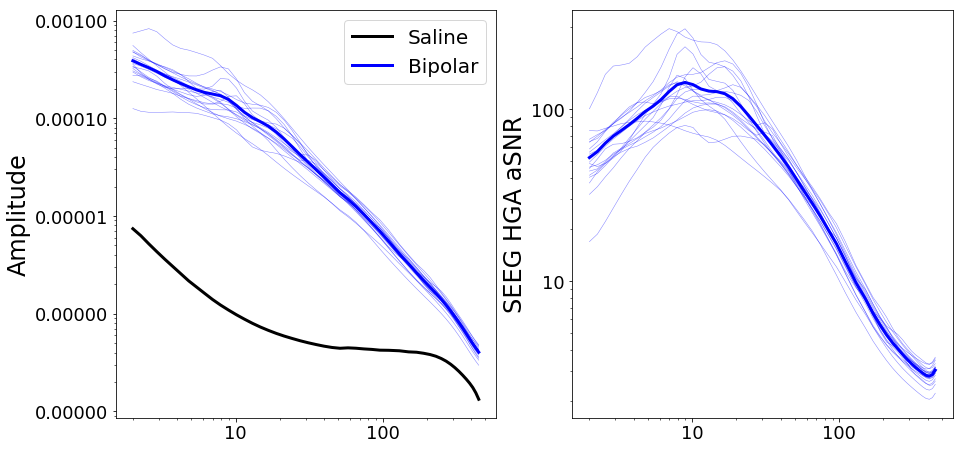

In [22]:
fig, axes = plt.subplots(figsize=(15,7.5), ncols=2)

axes[0].loglog(frequencies, saline_amp, color='black', lw=3, label='Saline')
axes[0].loglog(frequencies, subjectwise_amp_bipo.mean(axis=0), color='blue', lw=3, label='Bipolar')
axes[0].loglog(frequencies, subjectwise_amp_bipo.T, color='blue', lw=0.5, alpha=0.5)

axes[1].loglog(frequencies, (subjectwise_amp_bipo / saline_amp).mean(axis=0), color='blue', lw=3)
axes[1].loglog(frequencies, (subjectwise_amp_bipo / saline_amp).T, color='blue', lw=0.5, alpha=0.5)

# axes[1].loglog(frequencies, (subjectwise_amp_cw / saline_amp).mean(axis=0), color='green', lw=3)
# axes[1].loglog(frequencies, (subjectwise_amp_cw / saline_amp).T, color='green', lw=0.5, alpha=0.5)

for ax, label in zip(axes, ['Amplitude', 'SEEG HGA aSNR']):
    ax.tick_params(labelsize=18)
    ax.set_ylabel(label, fontsize=24)
    
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())
    
axes[0].legend(fontsize=20)
fig.savefig('asnr.pdf')

In [23]:
orig_psds = list()

for fname in glob.glob('derivatives/plv_spectrum_no_ez/*with_lp.pickle'):
    res_data = pickle.load(open(fname, 'rb'))
    orig_psds.append(res_data['psds'].mean(axis=0))
    
orig_psds = np.array(orig_psds)

orig_5, orig_95 = np.percentile(orig_psds, (5,95), axis=0)

In [24]:
data_psd_boot = subjectwise_psds.copy()
saline_psd_boot = saline_psd[1].copy()

d_psd_5, d_psd_95 = np.percentile(data_psd_boot, (5,95), axis=0)
s_psd_5, s_psd_95 = np.percentile(saline_psd_boot, (5, 95), axis=0)

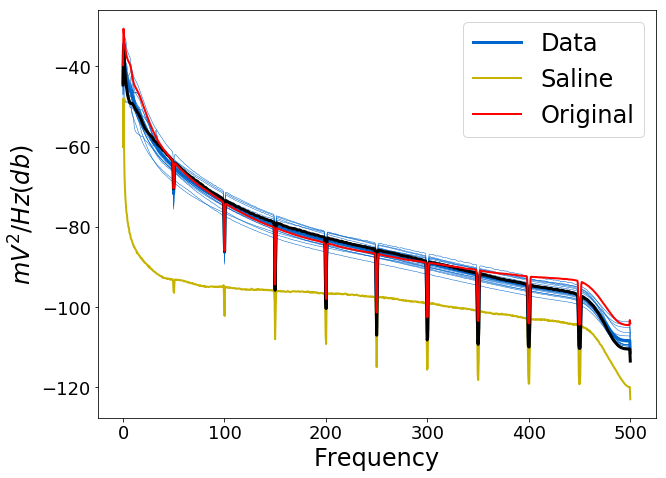

In [25]:
fig, ax = plt.subplots(figsize=(10,7.5))

ax.plot(saline_psd[0], data_psd_boot.mean(axis=0), color=ripples_blue, lw=3, label='Data')
ax.plot(saline_psd[0], data_psd_boot.T, color=ripples_blue, lw=0.5)

ax.plot(saline_psd[0], saline_psd_boot.mean(axis=0), color=ripples_orange, lw=2, label='Saline')
ax.plot(saline_psd[0], subjectwise_psds[~0], color='black', lw=3)
ax.plot(saline_psd[0], orig_psds.mean(axis=0), color='red', lw=2, label='Original')

ax.set_ylabel(r'$mV^2/Hz(db)$', fontsize=24)
ax.set_xlabel('Frequency', fontsize=24)

ax.tick_params(labelsize=18)

ax.legend(fontsize=24)

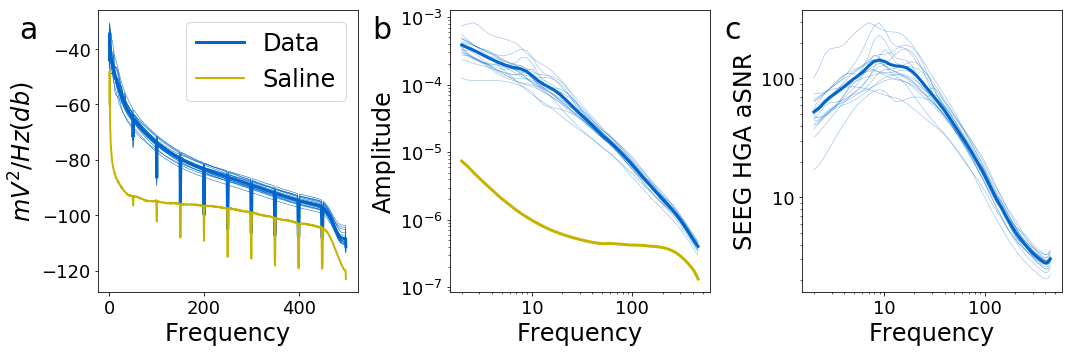

In [26]:
fig, axes = plt.subplots(figsize=(15,5), ncols=3)

axes[0].plot(saline_psd[0], data_psd_boot.mean(axis=0), color=ripples_blue, lw=3, label='Data')
axes[0].plot(saline_psd[0], data_psd_boot.T, color=ripples_blue, lw=0.5)
axes[0].plot(saline_psd[0], saline_psd_boot.mean(axis=0), color=ripples_orange, lw=2, label='Saline')

axes[1].loglog(frequencies, saline_amp, color=ripples_orange, lw=3, label='Saline')
axes[1].loglog(frequencies, subjectwise_amp_bipo.mean(axis=0), color=ripples_blue, lw=3, label='Bipolar')
axes[1].loglog(frequencies, subjectwise_amp_bipo.T, color=ripples_blue, lw=0.5, alpha=0.5)

axes[2].loglog(frequencies, (subjectwise_amp_bipo / saline_amp).mean(axis=0), color=ripples_blue, lw=3)
axes[2].loglog(frequencies, (subjectwise_amp_bipo / saline_amp).T, color=ripples_blue, lw=0.5, alpha=0.5)

for ax, label in zip(axes, [r'$mV^2/Hz(db)$', 'Amplitude', 'SEEG HGA aSNR']):
    ax.tick_params(labelsize=18)
    ax.set_ylabel(label, fontsize=24)
    
    if ax == axes[1]:
        ax.xaxis.set_major_formatter(ScalarFormatter())
    else:
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(ScalarFormatter())
        
    ax.set_xlabel('Frequency', fontsize=24)

fig.tight_layout()

axes[0].legend(fontsize=24)

axes[0].annotate('a', xy=(-0.3, 0.9), xycoords='axes fraction', fontsize=30)
axes[1].annotate('b', xy=(-0.3, 0.9), xycoords='axes fraction', fontsize=30)
axes[2].annotate('c', xy=(-0.3, 0.9), xycoords='axes fraction', fontsize=30)

fig.savefig('supp_asnr.svg', dpi=300)